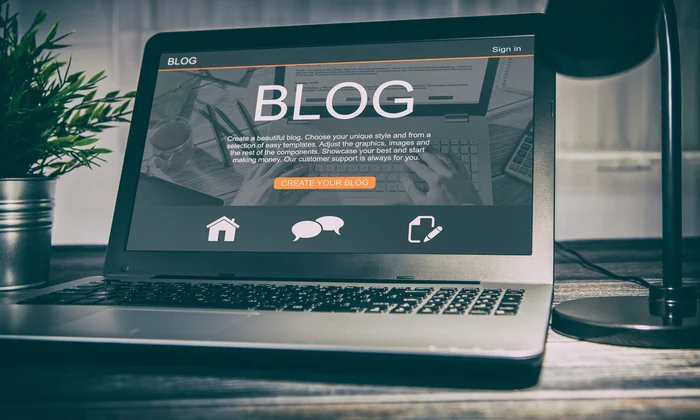

### 0. Setup the environment

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 1. Read the csv file

In [ ]:
df = pd.read_csv("../input/sample-blog-corpus/blogtext.csv")

### 2. Get the column names

In [ ]:
df.columns

### 3. Get the dataframe size

In [ ]:
df.shape

### 4. See some of the sample rows

In [ ]:
df.head()

### 5. Check if we have missing value for any columns

In [ ]:
df.isnull().sum()

### 6. Subset the data 

Make our data short during development. So that overall process takes less time to execute and we are able to rectify all the errors fast, and check if our code is running smoothly.
When everything is sorted at last, we will load about 1% of the data (~7K) as 681K rows is causing the notebook to crash

In [ ]:
df2 = df.head(7000)
#df2 = df

### 7. Preprocess text
#### 7.1 Preprocess values of text column

* Remove unwanted characters
* Convert text to lowercase
* Remove unwanted spaces
* Remove stopwords

In [ ]:
# Select only alphabets
import re
df2.text = df2.text.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

# Convert text to lowercase
df2.text = df2.text.apply(lambda x: x.lower())

# Strip unwanted spaces
df2.text = df2.text.apply(lambda x: x.strip())

# Remove stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
df2.text = df2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

### 7.2 Verify the preprocessing steps by looking over some values

In [ ]:
df2.text[5]

### 8. Merge the label coulmns

Merge all the label columns together, so that we have all the tags together for a particular sentence

In [ ]:
df2['labels'] = df2.apply(lambda row: [row['gender'], str(row['age']), 
                                       row['topic'], row['sign']], axis=1)

### 9. Select only required columns from your dataframe

In [ ]:
df3 = df2[['text','labels']]

### 10. Print the final dataframe

In [ ]:
df3.head()

### 11. Create training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3.text.values, df3.labels.values, 
                                                    test_size=0.20, random_state=42)

### 12. Vectorize the data
#### 12.1 Create Bag of Words
* Use CountVectorizer
* Transform the traing and testing data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### 13. Let us have a look at some feature names

In [ ]:
vectorizer.get_feature_names()[:6]

### 14. View term-document matrix

In [ ]:
X_train_bow.toarray()

### 15. Create a dictionary to get label counts

In [ ]:
label_counts = dict()

for labels in df3.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

### 16. Print the dictionary

In [ ]:
label_counts

### 17. Multi label binarizer
#### 17.1 Load a multilabel binarizer and fit it on the labels.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=sorted(label_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

### 18. Classifier
#### 18.1 Use a linear classifier of your choice, wrap it up in OneVsRestClassifier to train it on every label. (Code provided in project description)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf = OneVsRestClassifier(clf)

### 19. Fit the classifier

In [ ]:
clf.fit(X_train_bow, y_train)

### 20. Make predictions
* Get predicted labels and scores

In [ ]:
predicted_labels = clf.predict(X_test_bow)
predicted_scores = clf.decision_function(X_test_bow)

In [ ]:
pred_inversed = mlb.inverse_transform(predicted_labels)
y_test_inversed = mlb.inverse_transform(y_test)

### 21. Print 5 samples

In [ ]:
for i in range(5):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(pred_inversed[i])
    ))

### We see that the model is able to predict either exactly or a portion of the true label fairly accurately. Example 34,Sagittarius,female,indUnk is predicted correctly while 35,Aries,Technology,male is able to predict sometime correctly and other time till Aries,male only

### 22. Calculate accuracy
- Accuracy
- F1-score
- Precision
- Recall

### Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if we suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_val, predicted):
    print('Accuracy score: %.2f' %(accuracy_score(y_val, predicted)*100))
    print('F1 score (micro): %.2f' %(f1_score(y_val, predicted, average='micro')*100))
    print('Average precision score (micro): %.2f' %(average_precision_score(y_val, predicted, average='micro')*100))
    print('Average recall score (micro): %.2f' %(recall_score(y_val, predicted, average='micro')*100))
    print('F1 score (macro): %.2f' %(f1_score(y_val, predicted, average='macro')*100))
    print('Average precision score (macro): %.2f' %(average_precision_score(y_val, predicted, average='macro')*100))
    print('Average recall score (macro): %.2f' %(recall_score(y_val, predicted, average='macro')*100))

In [ ]:
print('Bag-of-words')
print_evaluation_scores(y_test, predicted_labels)

### Micro average makes sense here due to class imbalance

### 23. Plot the model metrics

#### We get a F1 score (micro method) of about 70% with the simplistic model

In [ ]:
import matplotlib.pyplot as plt
Recall = np.array([41.4,68.1,50.4,59.1])
label = np.array(['Accuracy score','F1 score (micro)',
                  'Avg precision score (micro)','Avg recall score(micro)'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Model metrics', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()